In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
data = preproc(data)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 3min 42s
Wall time: 3min 43s


In [7]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 15.6 ms
Wall time: 17.5 ms


# CV

### Definition

In [8]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler

In [9]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch='unrestricted',
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

In [10]:
model_names = ['A', 'B', 'vanilla_pre', 'vanilla_post', 'OT_pre', 'OT_post', 'random']
scores = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names},}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 23168.42it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 99 - Train Loss: 0.1711 / Validation Loss: 0.4999 / Train acc: 0.9389 / Val acc: 0.8069 / Learning Rate : 0.0000:   0%|          | 99/1000000 [03:36<604:46:24,  2.18s/it]

Training has converged after 99 epochs (lr < 1e-06)


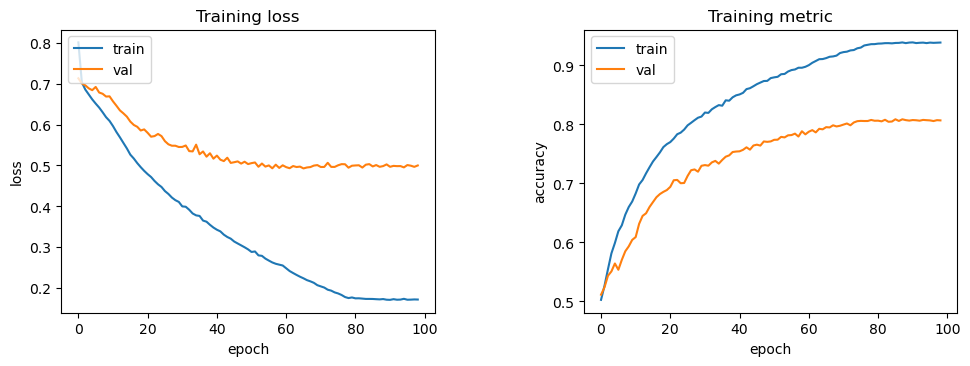

Epoch: 99 - Train Loss: 0.1711 / Validation Loss: 0.4999 / Train acc: 0.9389 / Val acc: 0.8069 / Learning Rate : 0.0000:   0%|          | 99/1000000 [03:36<607:18:44,  2.19s/it]


Starting training for model B


Epoch: 45 - Train Loss: 0.1641 / Validation Loss: 0.4102 / Train acc: 0.9416 / Val acc: 0.8340 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:38<604:09:59,  2.18s/it]

Training has converged after 45 epochs (lr < 1e-06)


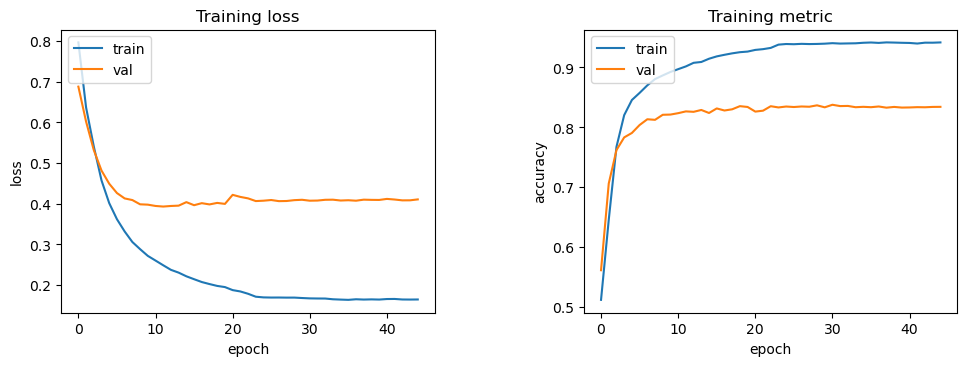

Epoch: 45 - Train Loss: 0.1641 / Validation Loss: 0.4102 / Train acc: 0.9416 / Val acc: 0.8340 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:38<606:38:08,  2.18s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 78 - Train Loss: 0.1957 / Validation Loss: 0.4591 / Train acc: 0.9337 / Val acc: 0.7982 / Learning Rate : 0.0000:   0%|          | 78/1000000 [02:42<576:51:47,  2.08s/it]

Training has converged after 78 epochs (lr < 1e-06)


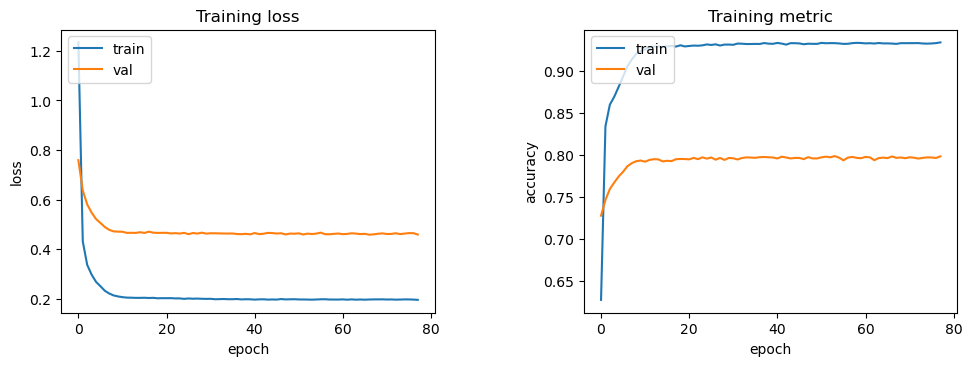

Epoch: 78 - Train Loss: 0.1957 / Validation Loss: 0.4591 / Train acc: 0.9337 / Val acc: 0.7982 / Learning Rate : 0.0000:   0%|          | 78/1000000 [02:43<580:42:26,  2.09s/it]


Starting retraining for model OT fusion


Epoch: 188 - Train Loss: 0.1830 / Validation Loss: 0.4972 / Train acc: 0.9331 / Val acc: 0.7959 / Learning Rate : 0.0000:   0%|          | 188/1000000 [06:32<577:44:43,  2.08s/it]

Training has converged after 188 epochs (lr < 1e-06)


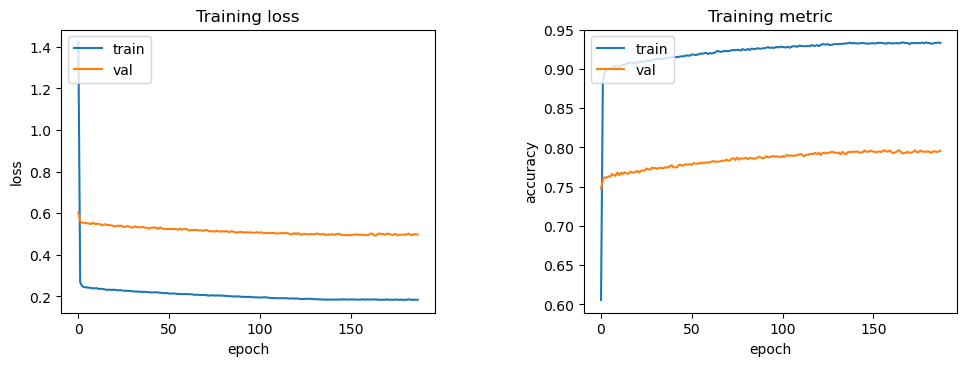

Epoch: 188 - Train Loss: 0.1830 / Validation Loss: 0.4972 / Train acc: 0.9331 / Val acc: 0.7959 / Learning Rate : 0.0000:   0%|          | 188/1000000 [06:32<579:54:14,  2.09s/it]


OT_post loss: 0.49284236629803974 - accuracy: 0.7966108091787439 - f1: 0.794854462146759
vanilla_post loss: 0.46151188264290494 - accuracy: 0.7964999433876812 - f1: 0.7970548272132874
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 22007.91it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 94 - Train Loss: 0.1804 / Validation Loss: 0.5191 / Train acc: 0.9339 / Val acc: 0.8062 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:24<603:24:53,  2.17s/it]

Training has converged after 94 epochs (lr < 1e-06)


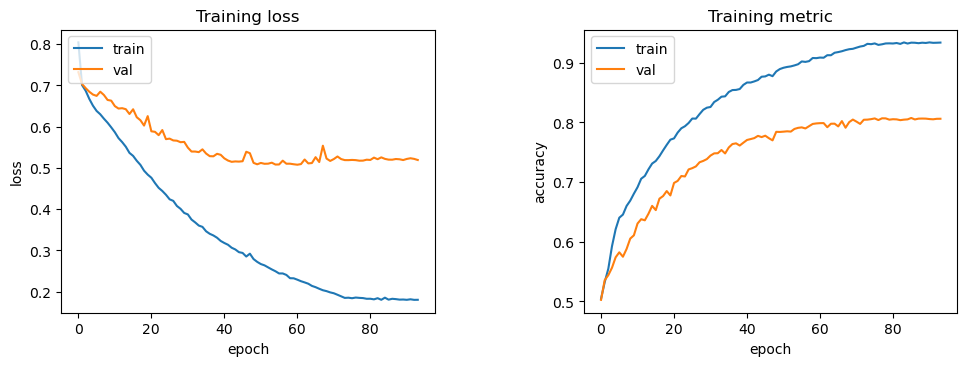

Epoch: 94 - Train Loss: 0.1804 / Validation Loss: 0.5191 / Train acc: 0.9339 / Val acc: 0.8062 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:24<605:30:15,  2.18s/it]


Starting training for model B


Epoch: 46 - Train Loss: 0.1715 / Validation Loss: 0.4251 / Train acc: 0.9381 / Val acc: 0.8290 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<602:56:11,  2.17s/it]

Training has converged after 46 epochs (lr < 1e-06)


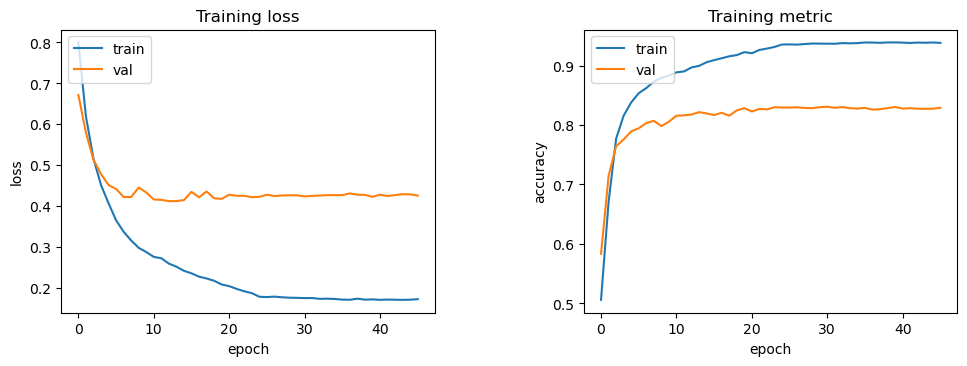

Epoch: 46 - Train Loss: 0.1715 / Validation Loss: 0.4251 / Train acc: 0.9381 / Val acc: 0.8290 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<606:37:45,  2.18s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 66 - Train Loss: 0.2065 / Validation Loss: 0.4757 / Train acc: 0.9321 / Val acc: 0.7904 / Learning Rate : 0.0000:   0%|          | 66/1000000 [02:18<580:47:05,  2.09s/it]

Training has converged after 66 epochs (lr < 1e-06)


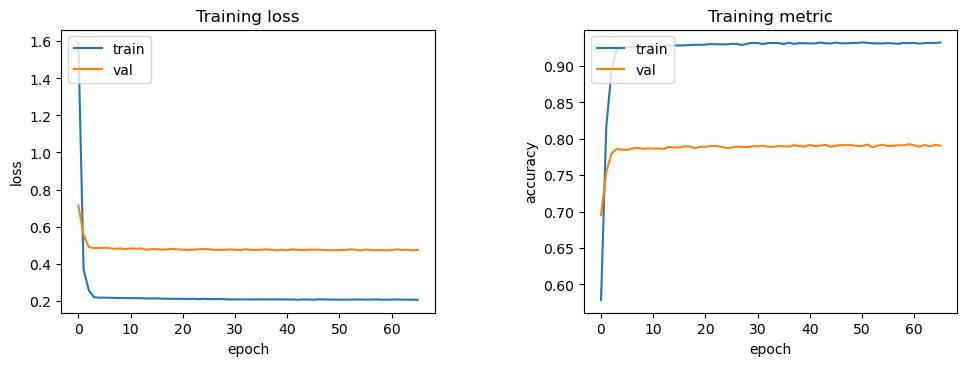

Epoch: 66 - Train Loss: 0.2065 / Validation Loss: 0.4757 / Train acc: 0.9321 / Val acc: 0.7904 / Learning Rate : 0.0000:   0%|          | 66/1000000 [02:18<581:52:19,  2.09s/it]


Starting retraining for model OT fusion


Epoch: 74 - Train Loss: 0.1932 / Validation Loss: 0.4681 / Train acc: 0.9343 / Val acc: 0.7986 / Learning Rate : 0.0000:   0%|          | 74/1000000 [02:34<578:07:17,  2.08s/it]

Training has converged after 74 epochs (lr < 1e-06)


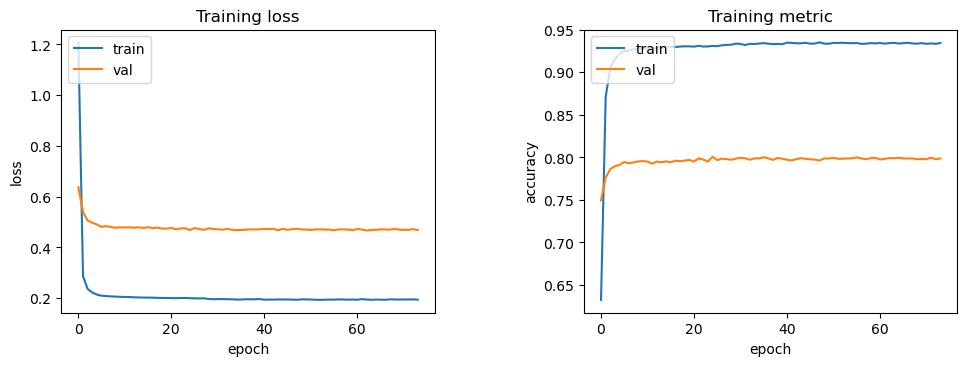

Epoch: 74 - Train Loss: 0.1932 / Validation Loss: 0.4681 / Train acc: 0.9343 / Val acc: 0.7986 / Learning Rate : 0.0000:   0%|          | 74/1000000 [02:34<580:16:53,  2.09s/it]


OT_post loss: 0.46991868565479916 - accuracy: 0.7988340008273165 - f1: 0.798443078994751
vanilla_post loss: 0.47300140808026 - accuracy: 0.7918006355294824 - f1: 0.7899814248085022
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22814.81it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 96 - Train Loss: 0.1826 / Validation Loss: 0.5322 / Train acc: 0.9353 / Val acc: 0.7944 / Learning Rate : 0.0000:   0%|          | 96/1000000 [03:29<606:27:53,  2.18s/it]

Training has converged after 96 epochs (lr < 1e-06)


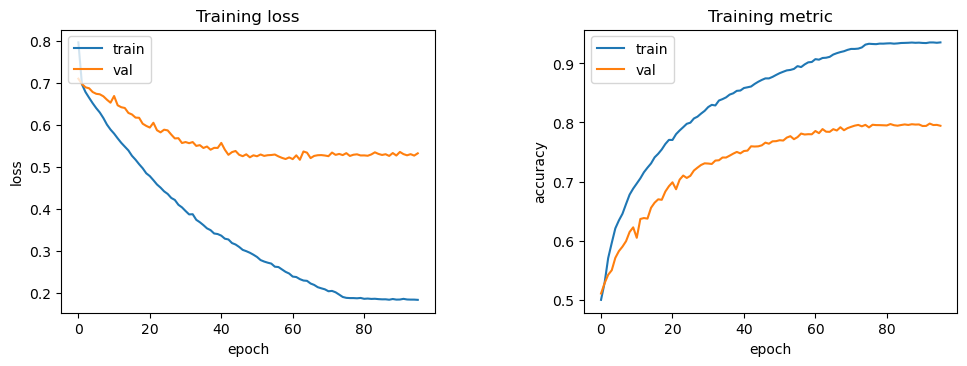

Epoch: 96 - Train Loss: 0.1826 / Validation Loss: 0.5322 / Train acc: 0.9353 / Val acc: 0.7944 / Learning Rate : 0.0000:   0%|          | 96/1000000 [03:29<606:50:01,  2.18s/it]


Starting training for model B


Epoch: 46 - Train Loss: 0.1650 / Validation Loss: 0.4178 / Train acc: 0.9413 / Val acc: 0.8356 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<603:43:06,  2.17s/it]

Training has converged after 46 epochs (lr < 1e-06)


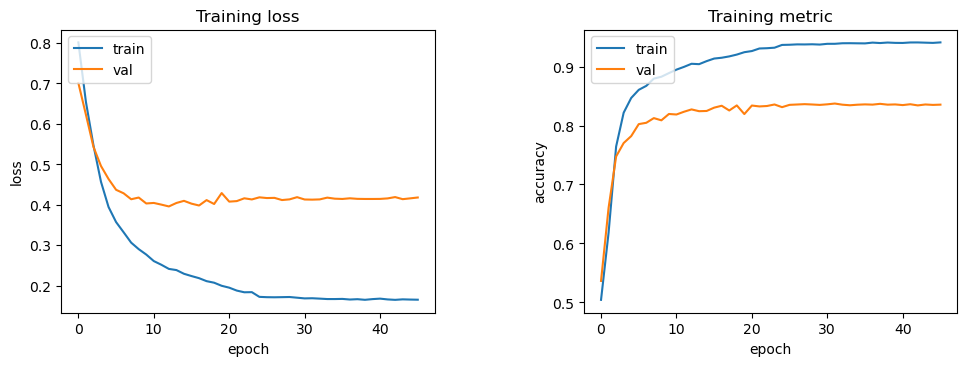

Epoch: 46 - Train Loss: 0.1650 / Validation Loss: 0.4178 / Train acc: 0.9413 / Val acc: 0.8356 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<606:56:25,  2.19s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 139 - Train Loss: 0.2000 / Validation Loss: 0.4762 / Train acc: 0.9327 / Val acc: 0.7920 / Learning Rate : 0.0000:   0%|          | 139/1000000 [04:50<578:12:34,  2.08s/it]

Training has converged after 139 epochs (lr < 1e-06)


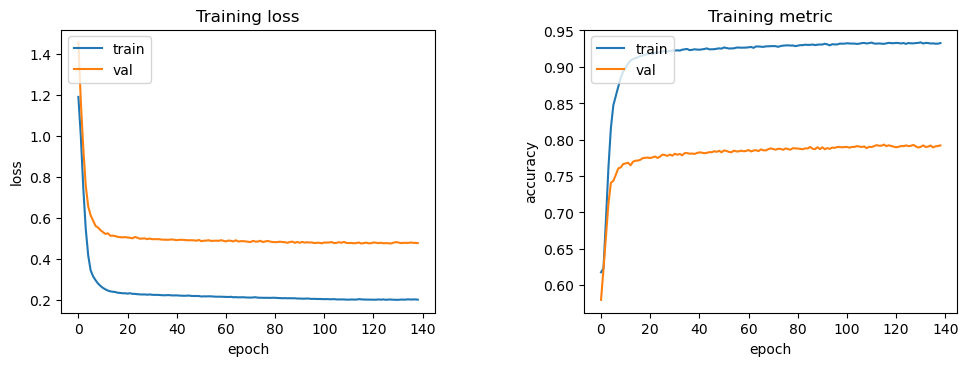

Epoch: 139 - Train Loss: 0.2000 / Validation Loss: 0.4762 / Train acc: 0.9327 / Val acc: 0.7920 / Learning Rate : 0.0000:   0%|          | 139/1000000 [04:50<580:29:15,  2.09s/it]


Starting retraining for model OT fusion


Epoch: 150 - Train Loss: 0.1849 / Validation Loss: 0.4791 / Train acc: 0.9374 / Val acc: 0.8011 / Learning Rate : 0.0000:   0%|          | 150/1000000 [05:13<578:22:57,  2.08s/it]

Training has converged after 150 epochs (lr < 1e-06)


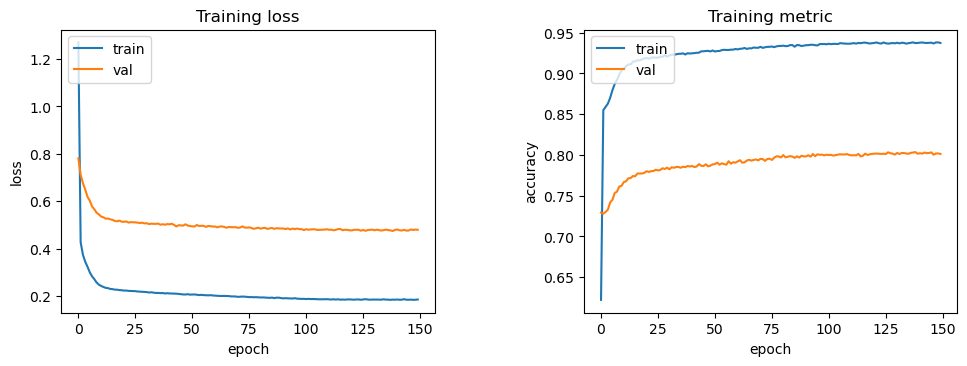

Epoch: 150 - Train Loss: 0.1849 / Validation Loss: 0.4791 / Train acc: 0.9374 / Val acc: 0.8011 / Learning Rate : 0.0000:   0%|          | 150/1000000 [05:13<580:00:29,  2.09s/it]


OT_post loss: 0.47874027987321216 - accuracy: 0.801813045276775 - f1: 0.8018277287483215
vanilla_post loss: 0.4763076951106389 - accuracy: 0.7912336181934416 - f1: 0.7908275723457336
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 15368.18it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 85 - Train Loss: 0.2034 / Validation Loss: 0.5294 / Train acc: 0.9236 / Val acc: 0.7939 / Learning Rate : 0.0000:   0%|          | 85/1000000 [03:05<604:33:36,  2.18s/it]

Training has converged after 85 epochs (lr < 1e-06)


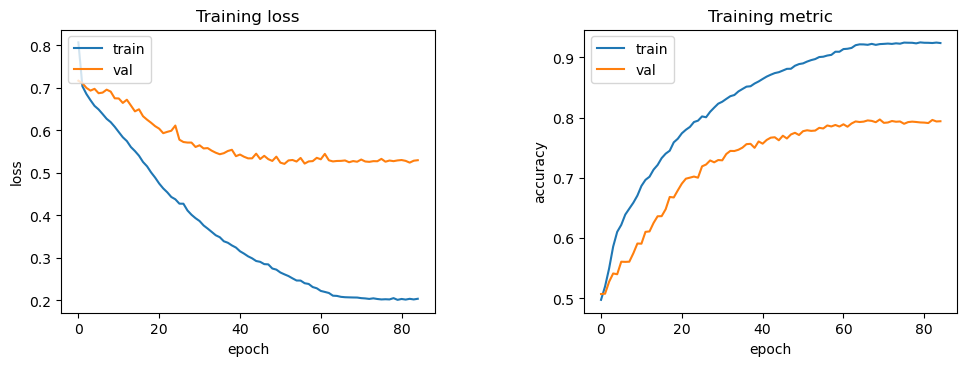

Epoch: 85 - Train Loss: 0.2034 / Validation Loss: 0.5294 / Train acc: 0.9236 / Val acc: 0.7939 / Learning Rate : 0.0000:   0%|          | 85/1000000 [03:05<606:08:45,  2.18s/it]


Starting training for model B


Epoch: 46 - Train Loss: 0.1822 / Validation Loss: 0.4500 / Train acc: 0.9332 / Val acc: 0.8166 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<604:10:08,  2.18s/it]

Training has converged after 46 epochs (lr < 1e-06)


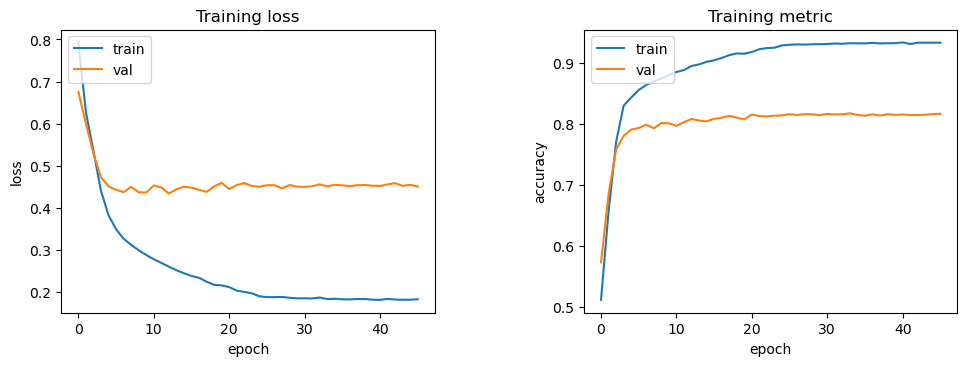

Epoch: 46 - Train Loss: 0.1822 / Validation Loss: 0.4500 / Train acc: 0.9332 / Val acc: 0.8166 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<607:49:41,  2.19s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 79 - Train Loss: 0.1960 / Validation Loss: 0.4652 / Train acc: 0.9327 / Val acc: 0.7957 / Learning Rate : 0.0000:   0%|          | 79/1000000 [02:45<578:55:16,  2.08s/it]

Training has converged after 79 epochs (lr < 1e-06)


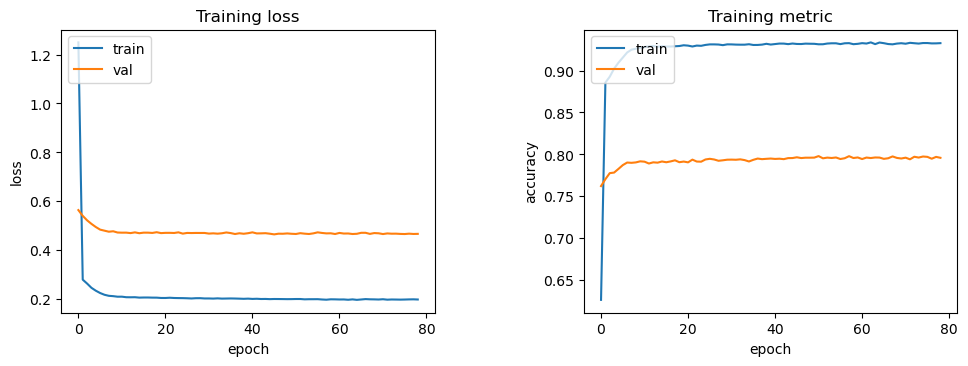

Epoch: 79 - Train Loss: 0.1960 / Validation Loss: 0.4652 / Train acc: 0.9327 / Val acc: 0.7957 / Learning Rate : 0.0000:   0%|          | 79/1000000 [02:45<580:47:20,  2.09s/it]


Starting retraining for model OT fusion


Epoch: 57 - Train Loss: 0.2125 / Validation Loss: 0.4560 / Train acc: 0.9294 / Val acc: 0.7942 / Learning Rate : 0.0000:   0%|          | 57/1000000 [01:59<586:11:01,  2.11s/it]

Training has converged after 57 epochs (lr < 1e-06)


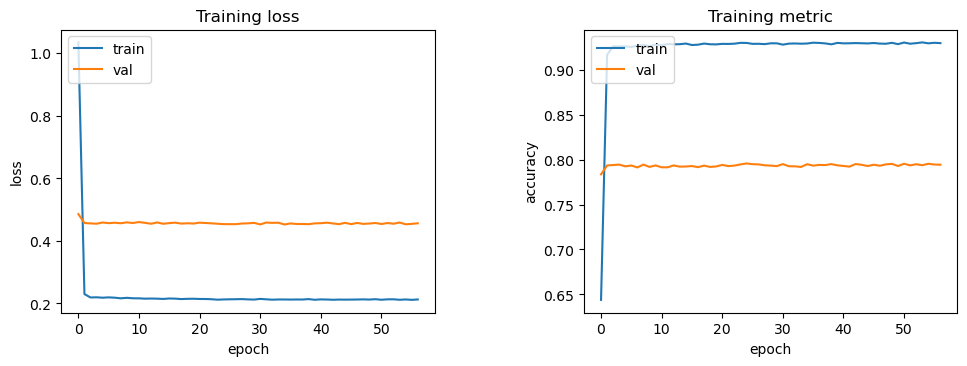

Epoch: 57 - Train Loss: 0.2125 / Validation Loss: 0.4560 / Train acc: 0.9294 / Val acc: 0.7942 / Learning Rate : 0.0000:   0%|          | 57/1000000 [01:59<581:14:01,  2.09s/it]


OT_post loss: 0.45433654884497326 - accuracy: 0.7960324063628158 - f1: 0.7943814396858215
vanilla_post loss: 0.46857945372660953 - accuracy: 0.7957268633423586 - f1: 0.796073853969574
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22131.23it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 86 - Train Loss: 0.1960 / Validation Loss: 0.4857 / Train acc: 0.9261 / Val acc: 0.8092 / Learning Rate : 0.0000:   0%|          | 86/1000000 [03:07<608:04:09,  2.19s/it]

Training has converged after 86 epochs (lr < 1e-06)


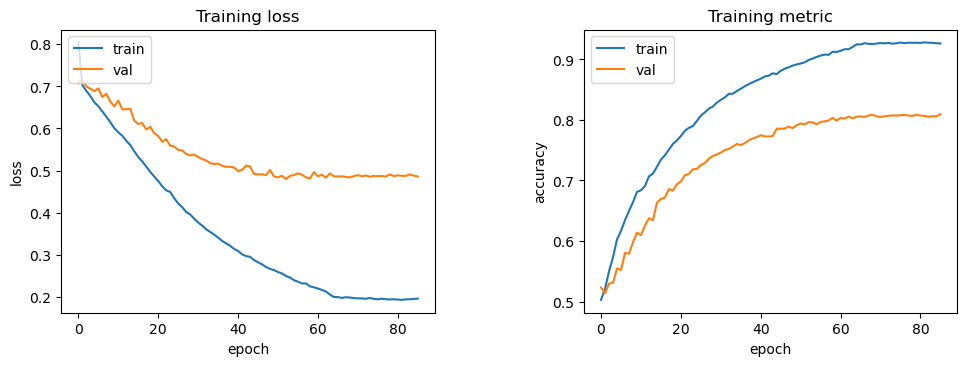

Epoch: 86 - Train Loss: 0.1960 / Validation Loss: 0.4857 / Train acc: 0.9261 / Val acc: 0.8092 / Learning Rate : 0.0000:   0%|          | 86/1000000 [03:07<606:38:59,  2.18s/it]


Starting training for model B


Epoch: 47 - Train Loss: 0.1555 / Validation Loss: 0.4155 / Train acc: 0.9444 / Val acc: 0.8364 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:42<603:37:05,  2.17s/it]

Training has converged after 47 epochs (lr < 1e-06)


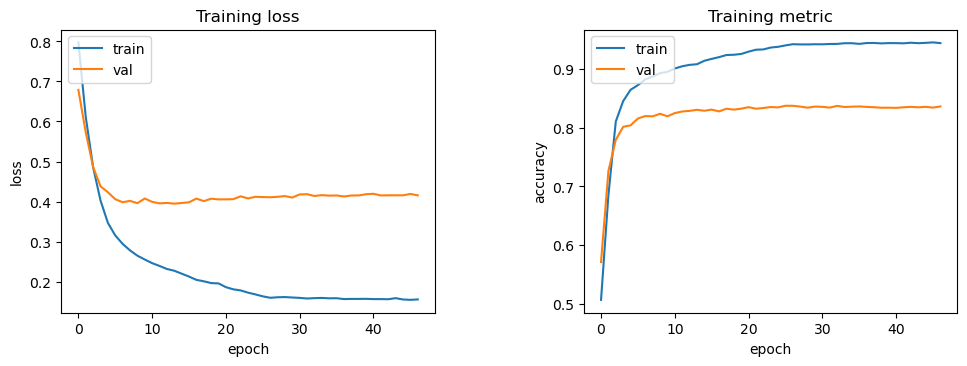

Epoch: 47 - Train Loss: 0.1555 / Validation Loss: 0.4155 / Train acc: 0.9444 / Val acc: 0.8364 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:42<607:26:30,  2.19s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 77 - Train Loss: 0.1844 / Validation Loss: 0.4338 / Train acc: 0.9410 / Val acc: 0.8101 / Learning Rate : 0.0000:   0%|          | 77/1000000 [02:40<583:48:12,  2.10s/it]

Training has converged after 77 epochs (lr < 1e-06)


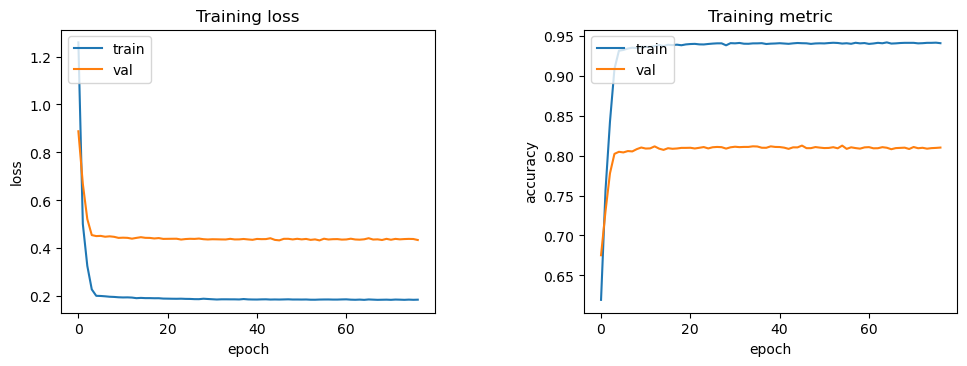

Epoch: 77 - Train Loss: 0.1844 / Validation Loss: 0.4338 / Train acc: 0.9410 / Val acc: 0.8101 / Learning Rate : 0.0000:   0%|          | 77/1000000 [02:41<581:11:19,  2.09s/it]


Starting retraining for model OT fusion


Epoch: 69 - Train Loss: 0.1834 / Validation Loss: 0.4355 / Train acc: 0.9426 / Val acc: 0.8094 / Learning Rate : 0.0000:   0%|          | 69/1000000 [02:24<586:25:15,  2.11s/it]

Training has converged after 69 epochs (lr < 1e-06)


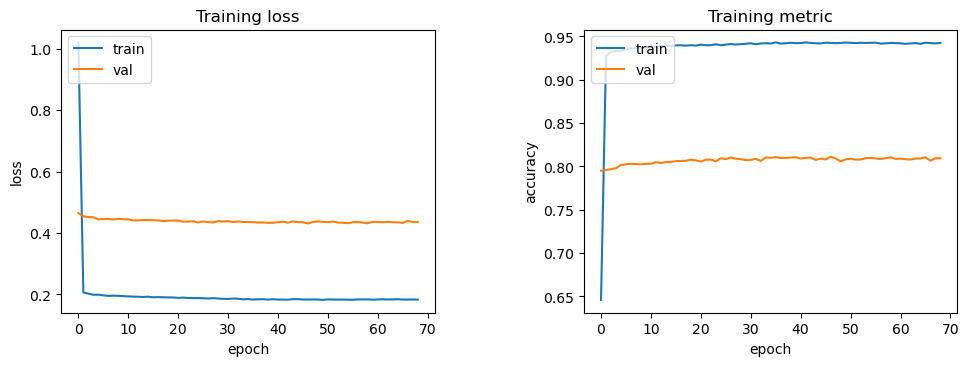

Epoch: 69 - Train Loss: 0.1834 / Validation Loss: 0.4355 / Train acc: 0.9426 / Val acc: 0.8094 / Learning Rate : 0.0000:   0%|          | 69/1000000 [02:24<581:22:43,  2.09s/it]


OT_post loss: 0.4381714314222336 - accuracy: 0.8082594154256919 - f1: 0.8091048002243042
vanilla_post loss: 0.43866358200709027 - accuracy: 0.8086243043020458 - f1: 0.8087663054466248
CPU times: total: 1h 10min 16s
Wall time: 1h 1min 31s


In [11]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        train_parent = lambda x: train_early_stopping(model_name=x,
                                                      train_iter=train_iterator,
                                                      valid_iter=test_iterator,
                                                      embedding=embedding,
                                                      pad_idx=pad_idx,
                                                      voc_size=voc_size,
                                                      device=device,
                                                      lr=LEARNING_RATE,
                                                      save=False)
        print('Starting training for model A')
        modelA = train_parent('A')
        print('Starting training for model B')
        modelB = train_parent('B')

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        N_TRIALS = 100
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight:', best_weighting_factor)
        model_fusion = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor)

        # evaluate
        # ensure all models on same device
        model_to_cpu = lambda x: x.to(device)
        modelA = model_to_cpu(modelA)
        modelB = model_to_cpu(modelB)
        model_random = new_model(embedding, pad_idx, voc_size, device)
        model_fusion = model_to_cpu(model_fusion)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('A', 'B', 'random', 'OT_pre', 'vanilla_pre'), (modelA, modelB, model_random, model_fusion, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        retrain = lambda x: train(model=x,
                                  iterator=train_iterator,
                                  valid_iter=test_iterator,
                                  optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                                  criterion=nn.CrossEntropyLoss(),
                                  epoch='unrestricted',
                                  clip=1,
                                  device=device)
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        retrain(model_fusion_vanilla)

        # 2) optimal transport
        # train with early stopping
        print('Starting retraining for model OT fusion')
        retrain(model_fusion)

        # evaluate
        # ensure all models on same device
        model_fusion = model_to_cpu(model_fusion)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('OT_post', 'vanilla_post'), (model_fusion, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [12]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport', 'Optimal transport (retraining)', 'Untrained model (baseline)']

In [13]:
latex = scores_to_latex(scores, model_names_latex)

                                             loss  \
A              [0.467, 0.482, 0.48, 0.505, 0.449]   
B             [0.408, 0.427, 0.417, 0.452, 0.414]   
vanilla_pre   [0.911, 0.912, 1.731, 0.574, 1.147]   
vanilla_post  [0.462, 0.473, 0.476, 0.469, 0.439]   
OT_pre        [0.666, 0.544, 0.775, 0.459, 0.479]   
OT_post        [0.493, 0.47, 0.479, 0.454, 0.438]   
random        [0.845, 0.732, 0.774, 0.796, 0.808]   

                                         accuracy  \
A              [0.83, 0.827, 0.819, 0.813, 0.825]   
B             [0.834, 0.828, 0.836, 0.816, 0.837]   
vanilla_pre     [0.703, 0.65, 0.55, 0.765, 0.626]   
vanilla_post  [0.796, 0.792, 0.791, 0.796, 0.809]   
OT_pre         [0.73, 0.776, 0.731, 0.791, 0.787]   
OT_post       [0.797, 0.799, 0.802, 0.796, 0.808]   
random        [0.492, 0.507, 0.491, 0.484, 0.493]   

                                               f1  
A             [0.831, 0.826, 0.819, 0.815, 0.824]  
B             [0.834, 0.828, 0.836, 0.815, 0.8

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\DL Project\CV\utils.py:925: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [14]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_seeds (weighted full retraining).txt','w') as dat:
    dat.write(str(latex))